# **Mapping metatranscriptomic reads to metagenomic assemblies**

In this notebook, we will:
1. Map metatranscriptomic reads to assembled contigs and directly to metagenomic reads using [**minimap2**](https://academic.oup.com/bioinformatics/article/34/18/3094/4994778)
2. Generate alignment statistics
3. Saturation Study

# **Map metaT reads using [Minimap2](https://github.com/lh3/minimap2)**:

## 2.1. **Within sample**
*Mapping of metaT reads to metaG reads from the same sample*

### metaT_heath → raw metaG_heath
```bash
minimap2 -ax map-ont metaG_heath.fastq metaT_heath_porechop_sortmerna.fastq > metaT_heath_vs_metaG_heath.sam
```
### metaT_wood → raw metaG_wood
```bash
minimap2 -ax map-ont metaG_wood.fastq metaT_wood_porechop_sortmerna.fastq > metaT_wood_vs_metaG_wood.sam
```

## 2.2. **Cross-Sample**
*Cross-mapping of metaT reads to metaG read from a different sample*

### metaT_wood → raw metaG_heath
```bash
minimap2 -ax map-ont metaG_heath.fastq metaT_wood_porechop_sortmerna.fastq > metaT_wood_vs_metaG_heath.sam
```

### metaT_heath → raw metaG_wood
```bash
minimap2 -ax map-ont metaG_wood.fastq metaT_heath_porechop_sortmerna.fastq > metaT_heath_vs_metaG_wood.sam
```

In [2]:
import pysam
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import subprocess

In [3]:
df_read_count = pd.read_csv("../../data/metatranscriptomics/mapping/read_counts_summary.csv")
display(df_read_count)

,Sample,Type,Origin,File,NumReads
0,wood,query,metaT,metaT_wood_porechop_not_rRNA.fasta,2343697
1,heath,query,metaT,metaT_heath_porechop_not_rRNA.fasta,922807
2,wood,reference,metaG,metaG_wood.fastq,156764
3,heath,reference,metaG,metaG_heath.fastq,219908


Construct a dictionary with the number of reads of each alignment file

In [4]:
reads_dict = {
    (row["Sample"], row["Type"]): row["NumReads"]
    for _, row in df_read_count.iterrows()
}

In [5]:
bam_dir = "../../data/metatranscriptomics/mapping/"
bam_files = [f for f in os.listdir(bam_dir) if f.endswith("_sorted.bam")]

#### **How many metaT and metaG reads are map between samples and across samples?**

In [6]:
df_read_count = pd.read_csv("../../data/metatranscriptomics/mapping/read_counts_summary.csv")


bam_files = [
    os.path.join(bam_dir, f)
    for f in os.listdir(bam_dir)
    if f.endswith("_sorted.bam") and "metaT" in f
]

results = []

for bam_file in bam_files:
    bam = pysam.AlignmentFile(bam_file, "rb")

    metaT_reads_mapped = set()
    metaG_reads_mapped = set()

    for read in bam.fetch(until_eof=True):
        if read.is_unmapped:
            continue

        metaT_reads_mapped.add(read.query_name)
        metaG_reads_mapped.add(read.reference_name)

    parts = os.path.basename(bam_file).replace("_sorted.bam", "").split("_vs_")
    metaT_sample = parts[0].replace("metaT_", "")
    reference_info = parts[1]
    reference_source = reference_info.replace("metaG_", "")

    total_metaT_reads = reads_dict.get((metaT_sample, "query"), 0)
    total_reference_reads = reads_dict.get((reference_source, "reference"), 0)

    percent_mapped_metaT = (len(metaT_reads_mapped) / total_metaT_reads) * 100 
    percent_mapped_metaG = (len(metaG_reads_mapped) / total_reference_reads) * 100 

    results.append({
        "metaT": metaT_sample,
        "ReferenceSource": reference_source,
        "metaT_ReadsMapped": len(metaT_reads_mapped),
        "TotalReads_metaT": total_metaT_reads,
        "TotalReads_reference": total_reference_reads,
        "PercentMapped_metaT": percent_mapped_metaT,
        "PercentMapped_metaG": percent_mapped_metaG
    })

df_mapped_result = pd.DataFrame(results)
print(df_mapped_result.to_string(index=False))


metaT ReferenceSource  metaT_ReadsMapped  TotalReads_metaT  TotalReads_reference  PercentMapped_metaT  PercentMapped_metaG
 wood            wood             114738           2343697                156764             4.895599             4.494654
heath            wood              30857            922807                156764             3.343819             2.299635
heath           heath              59615            922807                219908             6.460181             6.789657
 wood           heath             216106           2343697                219908             9.220731             4.877039


These values show the percentage of reads mapped in each BAM file relative to the total number of reads in the reference. However, for meaningful comparisons across samples, normalization is needed.

## **Saturation Study**
To determine if low mapping percentages are due to insufficient sequencing depth or reflect biological reality, we generate saturation curves.
1.  **Subsample** the reads at increasing depths.

In [7]:
! mkdir -p ../../data/metatranscriptomics/mapping/subsampling_output

In [8]:
!samtools view ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam | cut -f1 | sort | uniq > ../../data/metatranscriptomics/mapping/subsampling_output/heath_metaT_read_ids.txt
!samtools view ../../data/metatranscriptomics/mapping/metaT_wood_vs_metaG_wood_sorted.bam | cut -f1 | sort | uniq > ../../data/metatranscriptomics/mapping/subsampling_output/wood_metaT_read_ids.txt

In [9]:
!head ../../data/metatranscriptomics/mapping/subsampling_output/heath_metaT_read_ids.txt

SRR28223365.1
SRR28223365.10
SRR28223365.100
SRR28223365.10000
SRR28223365.100000
SRR28223365.1000000
SRR28223365.1000001
SRR28223365.1000004
SRR28223365.1000005
SRR28223365.1000007


In [10]:
!for sample in heath_metaT wood_metaT; do \
    for pct in 10 20 30 40 50 60 70 80 90 100; do \
        prob=$(echo "$pct / 100" | bc -l); \
        awk -v p=$prob 'BEGIN {srand(42)} rand() < p' ../../data/metatranscriptomics/mapping/subsampling_output/${sample}_read_ids.txt > ../../data/metatranscriptomics/mapping/subsampling_output/${sample}_ids_${pct}.txt; \
    done; \
done

2.  Calculate the **number of metagenomic reads mapped** at each subsample.

In [12]:
!../../data/metatranscriptomics/mapping/saturation_count.sh

🔄processing heath 10%...
🔄processing heath 20%...
🔄processing heath 30%...
🔄processing heath 40%...
🔄processing heath 50%...
🔄processing heath 60%...
🔄processing heath 70%...
🔄processing heath 80%...
🔄processing heath 90%...
🔄processing heath 100%...
🔄processing wood 10%...
🔄processing wood 20%...
🔄processing wood 30%...
🔄processing wood 40%...
🔄processing wood 50%...
🔄processing wood 60%...
🔄processing wood 70%...
🔄processing wood 80%...
🔄processing wood 90%...
🔄processing wood 100%...
result saved in ../../data/metatranscriptomics/mapping/subsampling_output/saturation_counts.tsv


3.  Plot mapped reads vs. sequencing depth.
4.  Look for saturation (plateau) indicating sufficient depth.

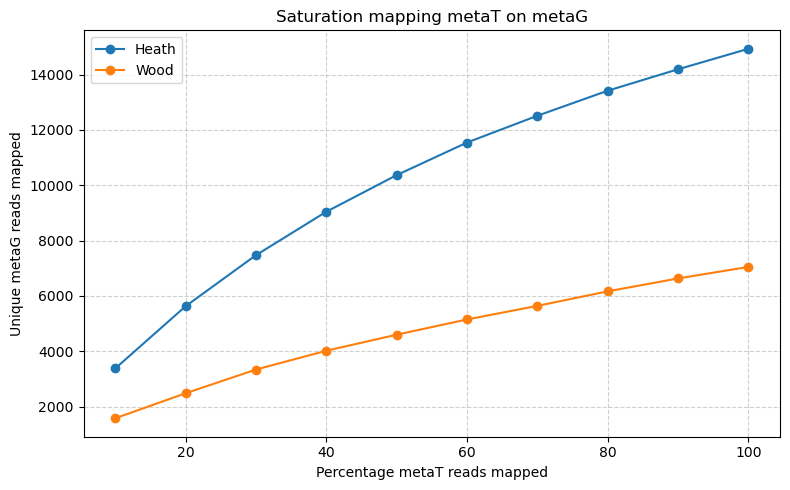

In [13]:
df = pd.read_csv("../../data/metatranscriptomics/mapping/subsampling_output/saturation_counts.tsv", sep="\t")

plt.figure(figsize=(8, 5))
for sample in df["Sample"].unique():
    sub = df[df["Sample"] == sample]
    plt.plot(sub["Percentage"], sub["UniqueRefs"], marker='o', label=sample.capitalize())

plt.title("Saturation mapping metaT on metaG")
plt.xlabel("Percentage metaT reads mapped")
plt.ylabel("Unique metaG reads mapped")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Do either of the curves shows signs of saturation? If not, what does it imply about the depth of sequencing?

How would you evaluate the saturation of the metagenomic reference?

# Types of alignment

When reads are mapped to a reference, they can have different types of alignments:

- **Primary Alignment**: The main (best) alignment for the read.

- **Secondary Alignment**: Alternative alignment(s), marked with *flag 0x100*. Often found in repetitive regions.

- **Supplementary Alignment**: Split alignment from a single read, often due to structural variation or chimeric reads. Marked with *flag 0x800*.

We can get flag information from a BAM file using [samstools flagstat](https://www.htslib.org/doc/1.11/samtools-flags.html)

In [18]:
!samtools flagstat ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam

1004086 + 0 in total (QC-passed reads + QC-failed reads)
922807 + 0 primary
81024 + 0 secondary
255 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
140894 + 0 mapped (14.03% : N/A)
59615 + 0 primary mapped (6.46% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Let's see an example of a read that map in different metaG reads with different types of alignment

In [28]:
!samtools view ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam | grep SRR28223365.476115 

SRR28223365.476115	2048	SRR28415665.11866	2704	60	25H23M1I71M1D28M557H	*	0	0	GGCAGGCACTGACCCAAACCAGTCCCGCGAGGTTGCGCGAGACATGTCCCCGTCGTCCAGTGGCCTAGGACACCGCCCTTTCACGGCGGTAACACAGTTCGAATCCCGTCGGGGACGCCAATC	*	NM:i:4	ms:i:220	AS:i:220	nn:i:0	tp:A:P	cm:i:10	s1:i:86	s2:i:70	de:f:0.0323	SA:Z:SRR28415665.135773,42,+,399S296M7I3S,12,60;	rl:i:0
SRR28223365.476115	256	SRR28415665.30390	904	0	25S12M1D27M1I2M1D53M1D26M559S	*	0	0	*	*	NM:i:8	ms:i:192	AS:i:192	nn:i:0	tp:A:S	cm:i:5	s1:i:70	de:f:0.0645	rl:i:0
SRR28223365.476115	272	SRR28415665.73287	3811	0	559S24M1D52M70S	*	0	0	*	*	NM:i:2	ms:i:140	AS:i:140	nn:i:0	tp:A:S	cm:i:6	s1:i:57	de:f:0.026	rl:i:0
SRR28223365.476115	0	SRR28415665.135773	42	12	399S16M1D53M2I1M2I2M1I12M1I2M1D100M1D7M3I4M1I9M3I2M1I6M1D3M3D72M3S	*	0	0	ATTACAATTCGGGTTACCGTTTGGGGGCAGGCACTGACCCAAACCAGTCCCGCGAGGTTGCGCGAGACATGTCCCCGTCGTCCAGTGGCCTAGGACACCGCCCTTTCACGGCGGTAACACAGTTCGAATCCCGTCGGGGACGCCAATCTTCTCAACAACTTGCGGAACTGCTTATTTTGGCCCACTACGGGCTACGCTACGGTTTAGCTGTTGGATGATACTGGAGTGCCCGGCTCAGTTT

**Primary alignment** (flag 0) is the best alignment (highest alignment score) chosen by minimap2. **Secondary alignments** (flag 256 and 272) are alternative places where the read could map to, usually with slightly worse alignment scores. The **supplementary alignment**(flag 2048) is a read mapped in a chimeric or split fashion. 

**SA field** (RefPos, CIGAR, MAPQ, X)

SA:Z:SRR28415665.135773,42,+,399S296M7I3S,12,60; -> points to the primary alignment

SA:Z:SRR28415665.11866,2704,+,25S123M557S,60,4; -> points to the first supplementary alignment, showing the split alignment

The second field correspond to the [SAM flag value](https://broadinstitute.github.io/picard/explain-flags.html) and it give us information about the properties of this read in the alignment. 

In [29]:
!samtools view ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam | grep SRR28223365.476115 | awk '{print $1,$3, $2, $6}'

SRR28223365.476115 SRR28415665.11866 2048 25H23M1I71M1D28M557H
SRR28223365.476115 SRR28415665.30390 256 25S12M1D27M1I2M1D53M1D26M559S
SRR28223365.476115 SRR28415665.73287 272 559S24M1D52M70S
SRR28223365.476115 SRR28415665.135773 0 399S16M1D53M2I1M2I2M1I12M1I2M1D100M1D7M3I4M1I9M3I2M1I6M1D3M3D72M3S


The sixth field correspond to the CIGAR field, which describes how the read aligns to the reference sequence - specifically, it shows which parts of the read matched, mismatched, were inserted, deleted or clipped.

In [20]:
def get_alignments(read_id, bam_file):
    cmd = f"samtools view {bam_file} | grep {read_id}"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    lines = result.stdout.strip().split("\n")

    alignments = []
    for line in lines:
        if not line.strip():
            continue
        fields = line.split("\t")
        qname = fields[0]
        flag = int(fields[1])
        rname = fields[2]      
        cigar = fields[5]

        is_secondary = bool(flag & 0x100)
        is_supplementary = bool(flag & 0x800)

        if is_secondary:
            read_type = "secondary"
        elif is_supplementary:
            read_type = "supplementary"
        else:
            read_type = "primary"

        alignments.append({
            "qname": qname,
            "flag": flag,
            "rname": rname,     
            "cigar": cigar,
            "type": read_type
        })

    return alignments

In [21]:
def parse_cigar(cigar):
    return [(int(length), op) for length, op in re.findall(r'(\d+)([MIDNSHP=X])', cigar)]

In [22]:
def plot_alignments(alignments, read_id="Read"):
    fig, ax = plt.subplots(figsize=(12, len(alignments)))
    type_colors = {
        "primary": "#1f77b4",       
        "secondary": "#ff7f0e",     
        "supplementary": "#2ca02c"  
    }

    cigar_colors = {
        "S": "#d3d3d3",    
        "I": "#9467bd",    
        "D": "#8c564b",    
        "H": "#4f4f4f"     
    }

    max_len = 0

    for i, aln in enumerate(alignments):
        parsed = parse_cigar(aln["cigar"])
        pos = 0
        for length, op in parsed:
            if op == "M":
                color = type_colors.get(aln["type"], "black")
            else:
                color = cigar_colors.get(op, "black")
        
            ax.add_patch(patches.Rectangle((pos, i), length, 0.6, color=color))
            if op in ("M", "I", "S","H" ):
                pos += length

        label = f"{aln['rname']} ({aln['type']})"
        ax.text(-5, i + 0.2, label, fontsize=8, ha='right')
        max_len = max(max_len, pos)

    ax.set_ylim(-0.5, len(alignments))
    ax.set_xlim(0, max_len + 20)
    ax.set_xlabel("Query position (bp)")
    ax.set_yticks([])
    ax.set_title(f"{read_id} alignments")

    legend_elements = [
        Line2D([0], [0], color="#1f77b4", lw=6, label="Primary (M)"),
        Line2D([0], [0], color="#ff7f0e", lw=6, label="Secondary (M)"),
        Line2D([0], [0], color="#2ca02c", lw=6, label="Supplementary (M)"),
        Line2D([0], [0], color="#d3d3d3", lw=6, label="Soft-clipped (S)"),
        Line2D([0], [0], color="#9467bd", lw=6, label="Insertion (I)"),
        Line2D([0], [0], color="#8c564b", lw=6, label="Deletion (D)"),
        Line2D([0], [0], color="#4f4f4f", lw=6, label="Hard-clipped (H)")
    ]
    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=9, borderaxespad=1)

    plt.tight_layout()
    plt.show()

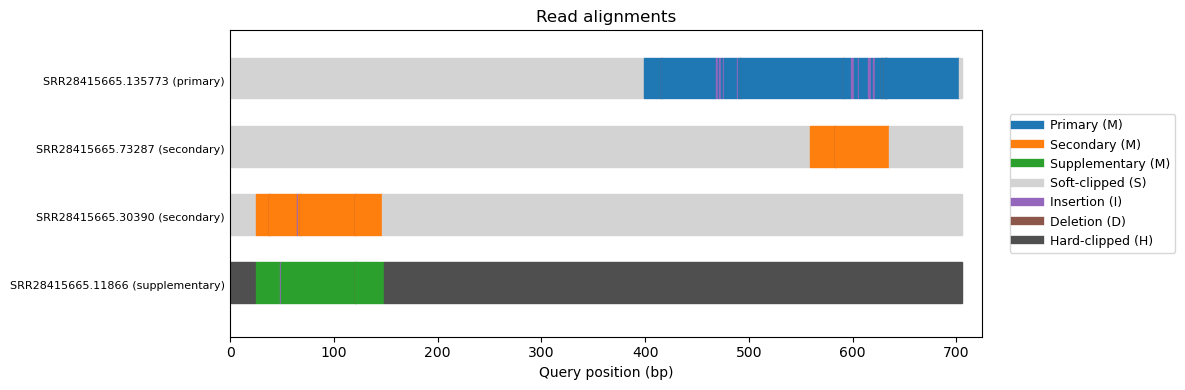

In [23]:
bam_file = "../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam"
read_id = "SRR28223365.476115"

aligns = get_alignments(read_id, bam_file)
plot_alignments(aligns)

Each horizontal bar represents one alignment segment of the read, with colors indicating alignment types and CIGAR operations

Different colors represent different types of alignment events:
- Blue, orange, and green bars correspond to **matched bases** in primary, secondary, and supplementary alignments respectively.
- Light grey bars represent **soft clipping (S)**, where bases at the ends of the reads do not align but are still present in the read sequence.
- Dark grey bars indicate **hard clipping (H)**, where bases are trimmed and not included in the alignment or read sequence.
- Purple bars show **insertions (I)** relative to the reference.
- Brown bars indicate **deletions (D)** in the read compared to the reference.

The x-axis shows the position along the read (query sequence) in base pairs.

Now we extract the flag information from each BAM file

In [24]:
!echo -e "bam_file\tprimary\tsecondary\tsupplementary" > ../../data/metatranscriptomics/mapping/flagstat_data.txt; for bam_file in ../../data/metatranscriptomics/mapping/*_sorted.bam; do echo "Processing $bam_file"; samtools flagstat "$bam_file" | awk -v bam="$bam_file" '/primary/ {primary = $1} /secondary/ {secondary = $1} /supplementary/ {supplementary = $1} END {print bam, primary, secondary, supplementary}' >> flagstat_data.txt; done

Processing ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_heath_sorted.bam
Processing ../../data/metatranscriptomics/mapping/metaT_heath_vs_metaG_wood_sorted.bam
Processing ../../data/metatranscriptomics/mapping/metaT_wood_vs_metaG_heath_sorted.bam
Processing ../../data/metatranscriptomics/mapping/metaT_wood_vs_metaG_wood_sorted.bam


In [25]:
results = []

In [26]:
bam_dir = "../../data/metatranscriptomics/mapping/"
bam_files = {
    bam.replace("_sorted.bam", ""): os.path.join(bam_dir, bam)
    for bam in os.listdir(bam_dir)
    if bam.endswith("_sorted.bam") and "metaG" in bam
}

In [46]:
from collections import defaultdict
import seaborn as sns

data = defaultdict(list)

for sample, bam_file in bam_files.items():

    parts=sample.split('_vs_')
    environment=parts[0].replace('metaT_','')
    reference=parts[1]
    
    bamfile = pysam.AlignmentFile(bam_file, "rb")

    for read in bamfile.fetch(until_eof=True):
        if read.is_unmapped:
            continue

        query_length = read.query_length
        aligned_query_bases = read.query_alignment_length

        if query_length == 0 or aligned_query_bases == 0:
            continue
        query_length_mapped=(aligned_query_bases/query_length) *100
        
        alignment_score = read.get_tag('AS') if read.has_tag('AS') else None

        flag = read.flag
        if flag & 0x800:
            alignment_type = "Supplementary"
        elif flag & 0x100:
            alignment_type = "Secondary"
        else:
            alignment_type = "Primary"

        data["Sample"].append(sample)
        data["ReadName"].append(read.query_name)
        data["Type"].append(alignment_type)
        data["AlignmentScore"].append(alignment_score)
        data["QueryLength_mapped(%)"].append(query_length_mapped)
        data["Reference"].append(reference)
        data["Environment"].append(environment)

df = pd.DataFrame(data)
df.head()


,Sample,ReadName,Type,AlignmentScore,QueryLength_mapped(%),Reference,Environment
0,metaT_wood_vs_metaG_wood,SRR28223359.2567967,Primary,412,63.917526,metaG_wood,wood
1,metaT_wood_vs_metaG_wood,SRR28223359.630021,Primary,88,14.647887,metaG_wood,wood
2,metaT_wood_vs_metaG_wood,SRR28223359.1264001,Primary,106,36.601307,metaG_wood,wood
3,metaT_wood_vs_metaG_wood,SRR28223359.4363,Primary,100,28.409091,metaG_wood,wood
4,metaT_wood_vs_metaG_wood,SRR28223359.1265025,Primary,106,53.333333,metaG_wood,wood


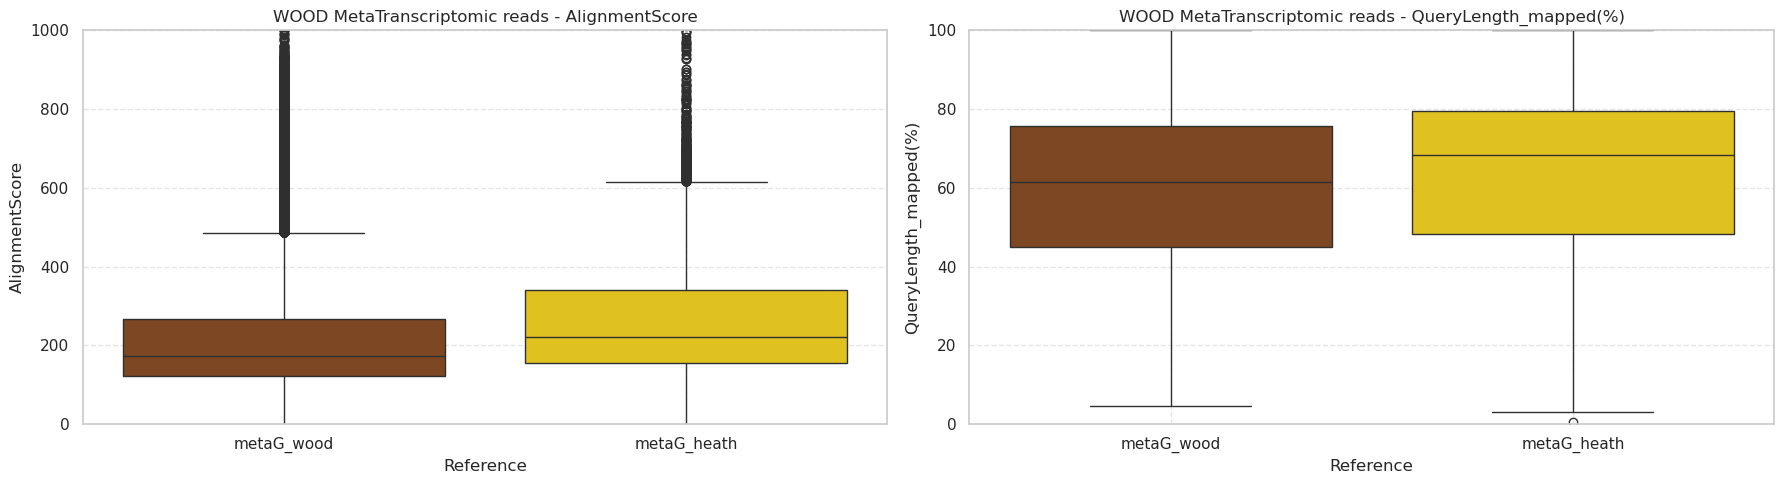

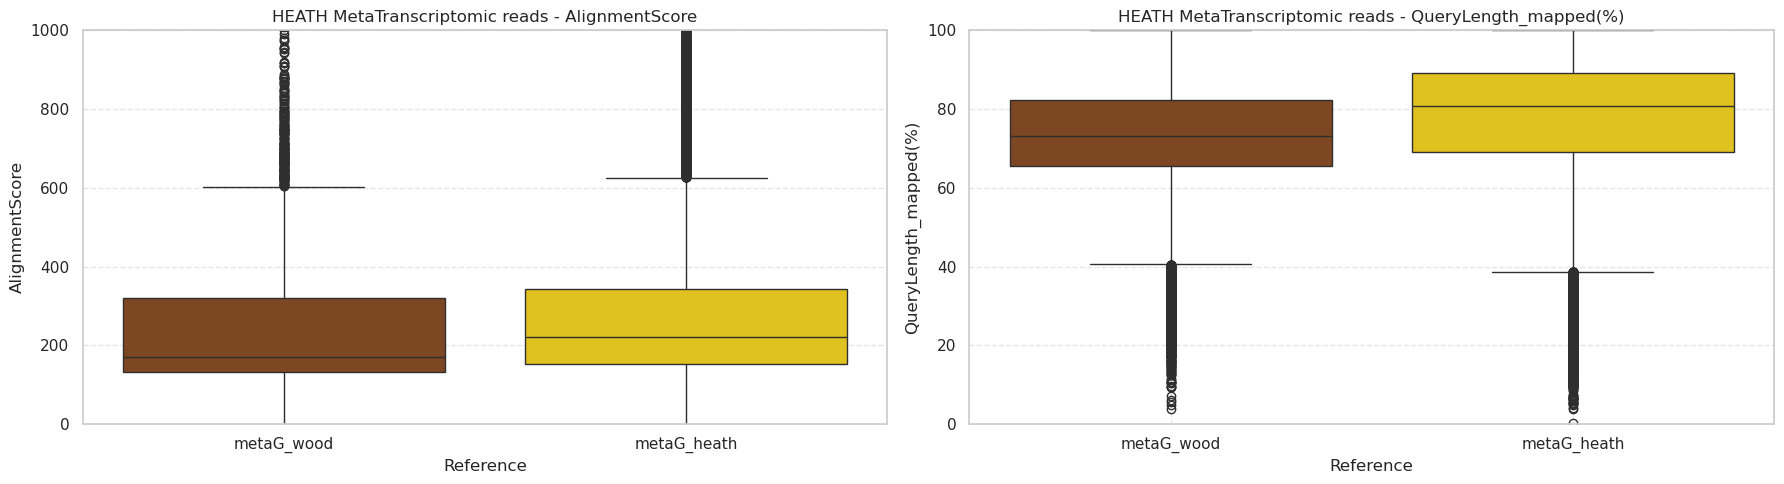

In [49]:

sns.set(style="whitegrid")
palette = {
    "metaG_wood": "#8B4513",     
    "metaG_heath": "#FFD700",    
}
df_primary = df[(df["Type"] == "Primary")]

for env in ["wood", "heath"]:
    df_env=df_primary[df_primary["Environment"]==env]

    
    plt.figure(figsize=(18, 5))
    for i, metric in enumerate(["AlignmentScore", "QueryLength_mapped(%)"]):
        plt.subplot(1, 2, i + 1)
        sns.boxplot(
            hue="Reference",
            x="Reference", 
            y=metric, 
            data=df_env,
            palette=palette,
            orientation='vertical'  
        )
        plt.title(f"{env.upper()} MetaTranscriptomic reads - {metric}")
        plt.grid(True, linestyle='--', alpha=0.5)

        if metric == "QueryLength_mapped(%)":
            plt.ylim(0,100)
        if metric == "AlignmentScore":
            plt.ylim(0,1000)
    plt.tight_layout()
    plt.show()

What might indicate that reads from wood map a higher percentage of their length against metaG heath?

What potential biases or limitations in the data or alignment process should we consider?  

What additional metrics or analyses would you include to better understand these mapping patterns?
